## Multi Linear regression 적용 (investment Decision : multi linear regression 방법)
- Train 데이터로 학습된 xgboost로 Test 데이터 평가 -> Fully - Paid라고 확신하는 데이터 남겨둔다.
- Train 데이터로 학습된 regression 모델로 Fully - Paid라고 확신한 데이터 regression 진행
- 상위 10% 데이터를 이용하여 portfolio를 만든다.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [12]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [13]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [15]:
data.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'installment', 'zip_code', 'revol_util',
       'fico_range_low', 'total_rev_hi_lim', 'revol_bal', 'bc_util',
       'avg_cur_bal', 'total_il_high_credit_limit', 'grade', 'total_pymnt',
       'total_pymnt_inv', 'loan_amnt', 'credit_history_years', 'term_months',
       'loan_status'],
      dtype='object')

In [16]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [18]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [19]:
data_y.value_counts()

loan_status
0              898669
1              217789
Name: count, dtype: int64

In [20]:
y_test.value_counts()

loan_status
0              599114
1              145192
Name: count, dtype: int64

In [21]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 893166 samples (80.0%)
Validation size: 223292 samples (20.0%)
Test size: 744306 samples (66.7%)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model_base = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.49195	validation_1-logloss:0.49198
[1]	validation_0-logloss:0.48735	validation_1-logloss:0.48740
[2]	validation_0-logloss:0.48287	validation_1-logloss:0.48294
[3]	validation_0-logloss:0.47852	validation_1-logloss:0.47860
[4]	validation_0-logloss:0.47427	validation_1-logloss:0.47438
[5]	validation_0-logloss:0.47013	validation_1-logloss:0.47026
[6]	validation_0-logloss:0.46610	validation_1-logloss:0.46624
[7]	validation_0-logloss:0.46217	validation_1-logloss:0.46233
[8]	validation_0-logloss:0.45833	validation_1-logloss:0.45851
[9]	validation_0-logloss:0.45459	validation_1-logloss:0.45478
[10]	validation_0-logloss:0.45093	validation_1-logloss:0.45114
[11]	validation_0-logloss:0.44735	validation_1-logloss:0.44758
[12]	validation_0-logloss:0.44386	validation_1-logloss:0.44411
[13]	validation_0-logloss:0.44044	validation_1-logloss:0.44071
[14]	validation_0-logloss:0.43710	validation_1-logloss:0.43738
[15]	validation_0-logloss:0.43384	validation_1-logloss:0.43413
[1

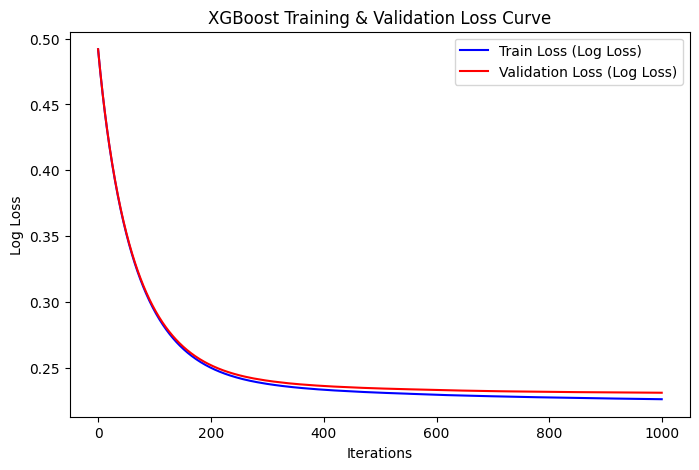

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    599114
           1       0.74      0.75      0.75    145192

    accuracy                           0.90    744306
   macro avg       0.84      0.84      0.84    744306
weighted avg       0.90      0.90      0.90    744306



In [25]:
model_base.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model_base.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model_base.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

In [26]:
##Base Method에서 test_regression set 모으기.
fully_paid_indices = (y_pred == 0)

test_regression = test_data[fully_paid_indices]

len(test_regression)

597899